<a href="https://colab.research.google.com/github/lucacamus13/update-LATAM/blob/main/update_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance investpy pandas matplotlib seaborn plotly pytz


In [43]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import pytz




# Comparativo bolsas LATAM

In [121]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import investpy

# Diccionario de índices con posibles tickers alternativos
indices = {
    'BRASIL': '^BVSP',
    'CHILE': 'SPCLXIPSA.SN', # Usar ticker de Santiago Exchange si ^IPSA falla
    'MÉXICO': '^MXX',
    'COLOMBIA': '^737809-COP-STRD', # Puede que siga fallando, pero lo mantenemos
    'PERÚ': '^SPBLPGPT' # Puede que siga fallando, pero lo mantenemos
}

# Función para verificar si la bolsa está abierta (comparando fechas)
def bolsa_abierta(ultima_fecha):
    hoy = datetime.now().date()
    # Asegurar que ultima_fecha es un objeto datetime
    if isinstance(ultima_fecha, pd.Timestamp):
        return 'ABIERTO' if ultima_fecha.date() == hoy else 'CERRADO'
    # Si no es un Timestamp de pandas, intentar convertirlo
    try:
        return 'ABIERTO' if pd.to_datetime(ultima_fecha).date() == hoy else 'CERRADO'
    except:
        return 'DESCONOCIDO' # Si falla la conversión, estado desconocido


# Crear DataFrame
datos_bolsas = []

for nombre, ticker in indices.items():
    try:
        # Intentar con yfinance primero
        data = yf.Ticker(ticker).history(period="2d")

        if len(data) >= 2:
            cierre_hoy = data['Close'].iloc[-1]
            cierre_ayer = data['Close'].iloc[-2]
            var_pct = ((cierre_hoy - cierre_ayer) / cierre_ayer) * 100
            estado = bolsa_abierta(data.index[-1])
            datos_bolsas.append({
                'Índice': nombre,
                'Estado': estado,
                'Nivel': round(cierre_hoy, 3),
                '1d%': round(var_pct, 2)
            })
        else:
             print(f"No hay suficientes datos de yfinance para {nombre} ({ticker}). Intentando con investpy si aplica.")
             # Intentar con investpy si es un índice conocido por investpy
             if nombre in ['CHILE', 'BRASIL', 'MÉXICO']: # Añadir otros si investpy los soporta bien
                try:
                    search_result = investpy.search_quotes(text=nombre, products=['indices'], countries=['chile', 'brazil', 'mexico'])
                    if search_result:
                        index_info = search_result[0] # Tomar el primer resultado
                        historical_data = investpy.get_index_historical_data(index=index_info.name,
                                                                             country=index_info.country,
                                                                             from_date=datetime.now().strftime('%d/%m/%Y'),
                                                                             to_date=datetime.now().strftime('%d/%m/%Y'))
                        if not historical_data.empty:
                             # Investpy a veces solo da el día actual, necesitamos el anterior
                             # Intentar obtener 2 días si es posible
                             historical_data_2d = investpy.get_index_historical_data(index=index_info.name,
                                                                                   country=index_info.country,
                                                                                   from_date=(datetime.now() - pd.Timedelta(days=5)).strftime('%d/%m/%Y'),
                                                                                   to_date=datetime.now().strftime('%d/%m/%Y'))
                             if len(historical_data_2d) >= 2:
                                cierre_hoy_inv = historical_data_2d['Close'].iloc[-1]
                                cierre_ayer_inv = historical_data_2d['Close'].iloc[-2]
                                var_pct_inv = ((cierre_hoy_inv - cierre_ayer_inv) / cierre_ayer_inv) * 100
                                estado_inv = bolsa_abierta(historical_data_2d.index[-1])
                                datos_bolsas.append({
                                    'Índice': nombre + ' (inv)', # Indicamos que viene de investpy
                                    'Estado': estado_inv,
                                    'Nivel': round(cierre_hoy_inv, 3),
                                    '1d%': round(var_pct_inv, 2)
                                })
                                print(f"✅ Datos de investpy obtenidos para {nombre}")
                             else:
                                print(f"No hay suficientes datos históricos recientes de investpy para {nombre}")
                        else:
                            print(f"No se encontraron datos recientes en investpy para {nombre}")
                    else:
                         print(f"No se encontró información del índice {nombre} en investpy")

                except Exception as investpy_e:
                    print(f"Error con investpy para {nombre}: {investpy_e}")


    except Exception as e:
        print(f"Error general con {nombre} ({ticker}): {e}")


# Crear DataFrame final
df_bolsas = pd.DataFrame(datos_bolsas)

if not df_bolsas.empty:
    # Asegurarse de que todas las columnas existen antes de reordenar
    required_cols = ['Índice', 'Estado', 'Nivel', '1d%']
    for col in required_cols:
        if col not in df_bolsas.columns:
            df_bolsas[col] = None # Añadir columna si falta

    df_bolsas = df_bolsas[required_cols]
    df_bolsas.sort_values('Índice', inplace=True)
    df_bolsas.reset_index(drop=True, inplace=True)

    # Mostrar
    print(df_bolsas)
else:
    print("No se pudieron obtener datos para ningún índice.")

ERROR:yfinance:$SPCLXIPSA.SN: possibly delisted; no price data found  (period=2d)


No hay suficientes datos de yfinance para CHILE (SPCLXIPSA.SN). Intentando con investpy si aplica.
Error con investpy para CHILE: ERR#0015: error 403, try again later.


ERROR:yfinance:$^SPBLPGPT: possibly delisted; no price data found  (period=2d)


No hay suficientes datos de yfinance para COLOMBIA (^737809-COP-STRD). Intentando con investpy si aplica.
No hay suficientes datos de yfinance para PERÚ (^SPBLPGPT). Intentando con investpy si aplica.
   Índice   Estado       Nivel   1d%
0  BRASIL  CERRADO  141478.000  0.39
1  MÉXICO  CERRADO   57977.762  0.15


# ETF's

In [122]:
import yfinance as yf
import pandas as pd

# Definimos tickers y nombres correctos
ticker_dict = {
    "EWZ": "ETF Brasil",
    "EWW": "ETF México",
    "ECH": "ETF Chile",
    "GXG": "ETF Colombia",
    "SPY": "S&P 500"
}

# Descargar precios ajustados
data = yf.download(list(ticker_dict.keys()), start="2024-07-01", end="2025-07-06")['Close']

# Renombrar columnas usando el diccionario
data = data.rename(columns=ticker_dict)

# Asegurar datos limpios
data = data.dropna()
data_norm = data / data.iloc[0] * 100


[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


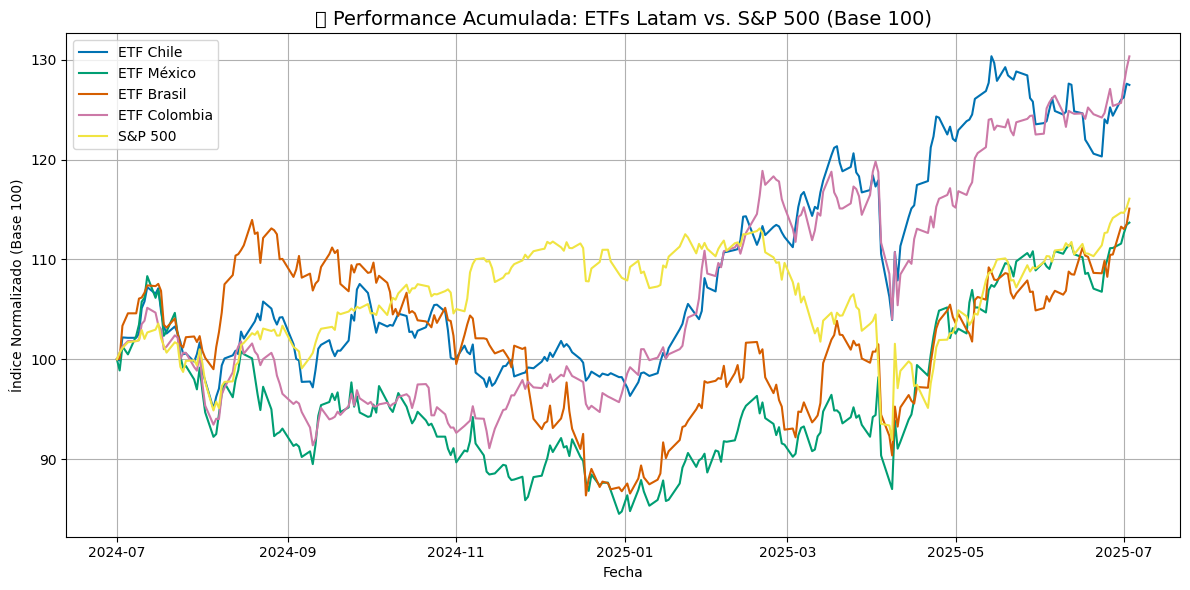

In [123]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Diccionario de tickers con nombres correctos
ticker_dict = {
    "EWZ": "ETF Brasil",
    #"ARGT": "ETF Argentina",
    "EWW": "ETF México",
    "ECH": "ETF Chile",
    "GXG": "ETF Colombia",
    "SPY": "S&P 500"
}

# Descargar precios ajustados (último año)
data = yf.download(list(ticker_dict.keys()), start="2024-07-01", end="2025-07-04")['Close']

# Renombrar columnas para que coincidan con países
data = data.rename(columns=ticker_dict)

# Eliminar fechas sin datos en todos los ETFs
data = data.dropna()

# Normalizar precios base 100 (rendimiento acumulado)
data_norm = data / data.iloc[0] * 100

# Graficar
plt.style.use("seaborn-v0_8-colorblind")
plt.figure(figsize=(12,6))
for col in data_norm.columns:
    plt.plot(data_norm.index, data_norm[col], label=col)

plt.title('📈 Performance Acumulada: ETFs Latam vs. S&P 500 (Base 100)', fontsize=14)
plt.ylabel('Índice Normalizado (Base 100)')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Monedas

Obteniendo datos de monedas latinoamericanas...
MONEDAS
Monedas      Precio       Var 1d     1d%     
--------------------------------------------------
REAL/USD     5.422        +0.012     +0.23%  
CLP/USD      929.000      +1.710     +0.18%  
MEX/USD      18.640       -0.006     -0.03%  
COP/USD      3,998.600    +10.350    +0.26%  
PEN/USD      3.547        -0.008     -0.23%  


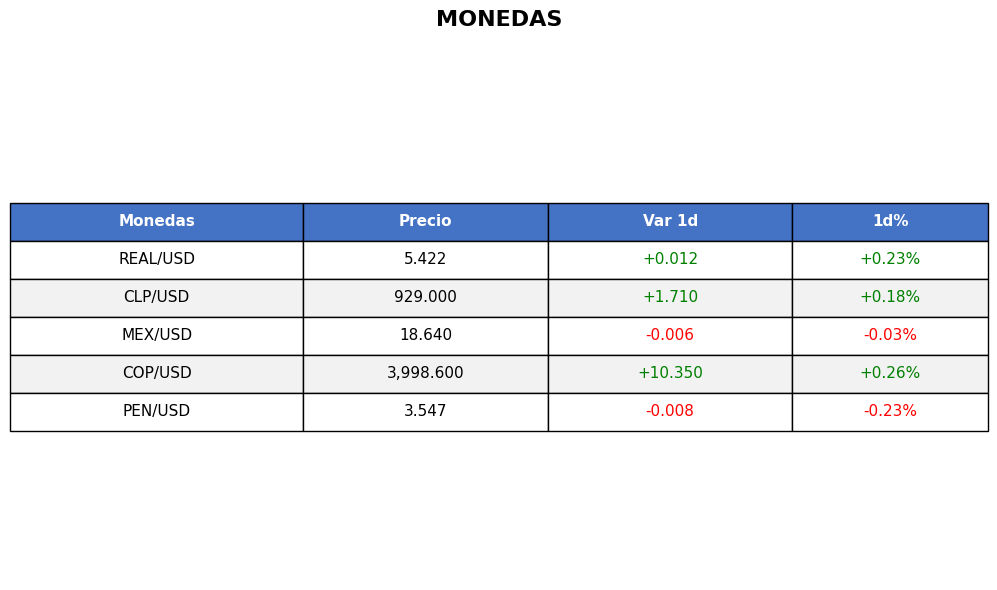

Imagen guardada como: monedas_latam.png


In [124]:

def get_currency_data():
    """Obtiene datos de monedas latinoamericanas vs USD"""

    # Símbolos de las monedas en Yahoo Finance
    currencies = {
        'REAL/USD': 'BRL=X',
        'CLP/USD': 'CLP=X',
        'MEX/USD': 'MXN=X',
        'COP/USD': 'COP=X',
        'PEN/USD': 'PEN=X'
    }

    results = []

    # Obtener datos para cada moneda
    for name, symbol in currencies.items():
        try:
            # Obtener datos de los últimos 5 días para calcular variación
            ticker = yf.Ticker(symbol)
            hist = ticker.history(period='5d')

            if len(hist) >= 2:
                # Precio actual (último precio disponible)
                current_price = hist['Close'].iloc[-1]

                # Precio anterior (día anterior)
                prev_price = hist['Close'].iloc[-2]

                # Calcular variación absoluta y porcentual
                var_1d = current_price - prev_price
                var_1d_pct = (var_1d / prev_price) * 100

                results.append({
                    'Monedas': name,
                    'Precio': current_price,
                    'Var 1d': var_1d,
                    '1d%': var_1d_pct
                })
            else:
                print(f"No hay suficientes datos para {name}")

        except Exception as e:
            print(f"Error obteniendo datos para {name}: {e}")

    return pd.DataFrame(results)

def create_currency_image(df, filename='monedas_latam.png'):
    """Crea una imagen PNG de la tabla de monedas"""

    if df.empty:
        print("No se puede crear imagen sin datos")
        return

    # Configurar la figura
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')

    # Preparar datos para la tabla
    table_data = []
    headers = ['Monedas', 'Precio', 'Var 1d', '1d%']

    # Formatear los datos
    for _, row in df.iterrows():
        precio = f"{row['Precio']:,.3f}"
        var_1d = f"{row['Var 1d']:+.3f}" if abs(row['Var 1d']) >= 0.001 else f"{row['Var 1d']:+.4f}"
        var_pct = f"{row['1d%']:+.2f}%"

        table_data.append([
            row['Monedas'],
            precio,
            var_1d,
            var_pct
        ])

    # Crear la tabla
    table = ax.table(cellText=table_data,
                    colLabels=headers,
                    cellLoc='center',
                    loc='center',
                    colWidths=[0.3, 0.25, 0.25, 0.2])

    # Estilo de la tabla
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)

    # Estilo del encabezado
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Estilo de las filas
    for i in range(1, len(table_data) + 1):
        for j in range(len(headers)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#F2F2F2')
            else:
                table[(i, j)].set_facecolor('white')

            # Colorear las variaciones
            if j == 2 or j == 3:  # Columnas de variación
                cell_text = table[(i, j)].get_text().get_text()
                if cell_text.startswith('+'):
                    table[(i, j)].set_text_props(color='green')
                elif cell_text.startswith('-'):
                    table[(i, j)].set_text_props(color='red')

    # Título
    plt.title('MONEDAS', fontsize=16, fontweight='bold', pad=20)

    # Guardar la imagen
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"Imagen guardada como: {filename}")

def format_currency_table(df):
    """Formatea la tabla para mostrar como en la imagen"""

    if df.empty:
        print("No se pudieron obtener datos de monedas")
        return

    print("MONEDAS")
    print("=" * 50)
    print(f"{'Monedas':<12} {'Precio':<12} {'Var 1d':<10} {'1d%':<8}")
    print("-" * 50)

    for _, row in df.iterrows():
        moneda = row['Monedas']
        precio = f"{row['Precio']:,.3f}"
        var_1d = f"{row['Var 1d']:+.3f}" if abs(row['Var 1d']) >= 0.001 else f"{row['Var 1d']:+.4f}"
        var_pct = f"{row['1d%']:+.2f}%"

        print(f"{moneda:<12} {precio:<12} {var_1d:<10} {var_pct:<8}")

def create_formatted_dataframe(df):
    """Crea un DataFrame formateado para mejor visualización"""

    if df.empty:
        return pd.DataFrame()

    # Crear copia del DataFrame
    formatted_df = df.copy()

    # Formatear columnas
    formatted_df['Precio'] = formatted_df['Precio'].apply(lambda x: f"{x:,.3f}")
    formatted_df['Var 1d'] = formatted_df['Var 1d'].apply(lambda x: f"{x:+.3f}" if abs(x) >= 0.001 else f"{x:+.4f}")
    formatted_df['1d%'] = formatted_df['1d%'].apply(lambda x: f"{x:+.2f}%")

    return formatted_df

# Función principal
def main():
    print("Obteniendo datos de monedas latinoamericanas...")

    # Obtener datos
    df = get_currency_data()

    if not df.empty:
        # Mostrar tabla formateada en consola
        format_currency_table(df)

        # Crear imagen PNG
        create_currency_image(df)

        return df
    else:
        print("No se pudieron obtener datos de ninguna moneda")
        return None

# Ejecutar el código
if __name__ == "__main__":
    currency_data = main()

# Comoditties

Obteniendo datos de commodities...
COMMODITIES
Futuros         Precio     1d%      1m%     
------------------------------------------------------------
Brent           67.74      -1.54%   +1.9%   
M. de hierro    54.8       +2.97%   +15.7%  
Cobre           5.03       -1.37%   +4.1%   
Litio           39.75      +1.95%   +7.3%   
Oro             3320.90    -0.32%   -0.1%   
Café            292.65     +0.00%   -18.3%  
Soja            1033.25    -2.18%   -2.3%   


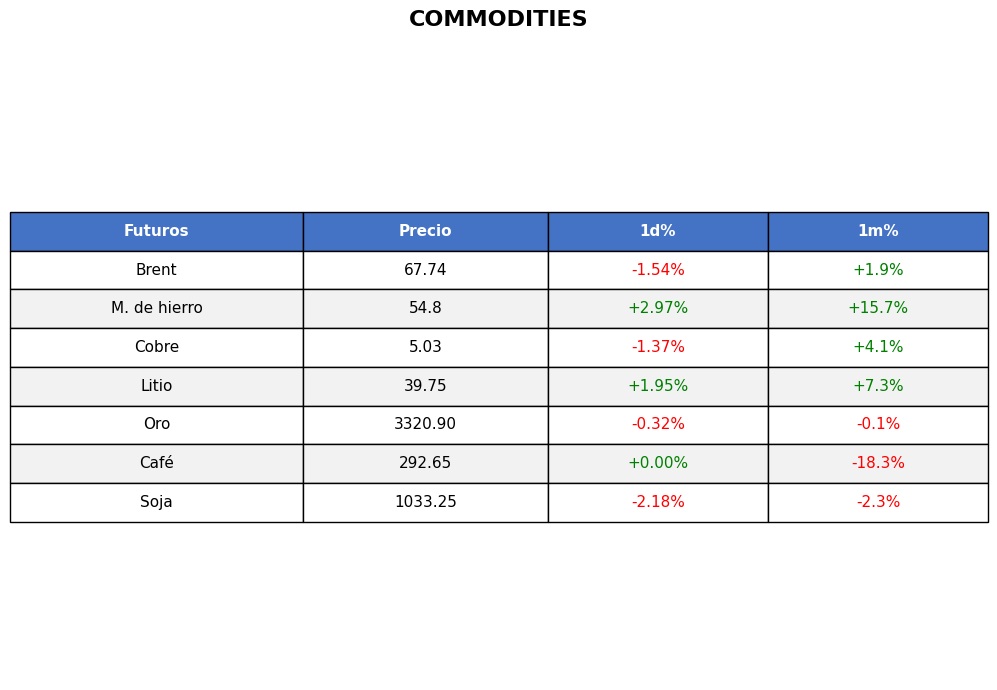

Imagen guardada como: commodities_actual.png


In [125]:


def get_commodities_data(fecha_especifica=None):
    """Obtiene datos de commodities/futuros"""

    # Símbolos de commodities en Yahoo Finance
    commodities = {
        'Brent': 'BZ=F',        # Petróleo Brent
        'M. de hierro': 'IRON',  # Mineral de hierro (puede no estar disponible)
        'Cobre': 'HG=F',        # Cobre futuros
        'Litio': 'LIT',         # ETF de Litio (alternativa)
        'Oro': 'GC=F',          # Oro futuros
        'Café': 'KC=F',         # Café futuros
        'Soja': 'ZS=F'          # Soja futuros
    }

    results = []

    # Obtener datos para cada commodity
    for name, symbol in commodities.items():
        try:
            ticker = yf.Ticker(symbol)

            if fecha_especifica:
                # Obtener datos desde una fecha específica
                fecha_inicio = datetime.strptime(fecha_especifica, '%Y-%m-%d') - timedelta(days=7)
                fecha_fin = datetime.strptime(fecha_especifica, '%Y-%m-%d') + timedelta(days=1)
                hist = ticker.history(start=fecha_inicio, end=fecha_fin)
            else:
                # Obtener datos de los últimos 5 días para calcular variación
                hist = ticker.history(period='5d')

            if len(hist) >= 2:
                # Precio actual (último precio disponible)
                current_price = hist['Close'].iloc[-1]

                # Precio anterior (día anterior)
                prev_price = hist['Close'].iloc[-2]

                # Precio hace 1 mes aproximadamente (22 días hábiles)
                hist_1m = ticker.history(period='1mo')
                if len(hist_1m) >= 22:
                    price_1m = hist_1m['Close'].iloc[-22]
                else:
                    price_1m = hist_1m['Close'].iloc[0]

                # Calcular variaciones
                var_1d = current_price - prev_price
                var_1d_pct = (var_1d / prev_price) * 100

                var_1m_pct = ((current_price - price_1m) / price_1m) * 100

                results.append({
                    'Futuros': name,
                    'Precio': current_price,
                    '1d%': var_1d_pct,
                    '1m%': var_1m_pct
                })
            else:
                print(f"No hay suficientes datos para {name}")

        except Exception as e:
            print(f"Error obteniendo datos para {name}: {e}")

    return pd.DataFrame(results)

def create_commodities_image(df, filename='commodities.png'):
    """Crea una imagen PNG de la tabla de commodities"""

    if df.empty:
        print("No se puede crear imagen sin datos")
        return

    # Configurar la figura
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.axis('tight')
    ax.axis('off')

    # Preparar datos para la tabla
    table_data = []
    headers = ['Futuros', 'Precio', '1d%', '1m%']

    # Formatear los datos
    for _, row in df.iterrows():
        # Formatear precio según el commodity
        if row['Futuros'] in ['Litio', 'Oro']:
            precio = f"{row['Precio']:.2f}"
        elif row['Futuros'] == 'M. de hierro':
            precio = f"{row['Precio']:.1f}"
        else:
            precio = f"{row['Precio']:.2f}"

        var_1d = f"{row['1d%']:+.2f}%"
        var_1m = f"{row['1m%']:+.1f}%"

        table_data.append([
            row['Futuros'],
            precio,
            var_1d,
            var_1m
        ])

    # Crear la tabla
    table = ax.table(cellText=table_data,
                    colLabels=headers,
                    cellLoc='center',
                    loc='center',
                    colWidths=[0.3, 0.25, 0.225, 0.225])

    # Estilo de la tabla
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)

    # Estilo del encabezado
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Estilo de las filas
    for i in range(1, len(table_data) + 1):
        for j in range(len(headers)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#F2F2F2')
            else:
                table[(i, j)].set_facecolor('white')

            # Colorear las variaciones
            if j == 2 or j == 3:  # Columnas de variación
                cell_text = table[(i, j)].get_text().get_text()
                if cell_text.startswith('+'):
                    table[(i, j)].set_text_props(color='green')
                elif cell_text.startswith('-'):
                    table[(i, j)].set_text_props(color='red')

    # Título
    plt.title('COMMODITIES', fontsize=16, fontweight='bold', pad=20)

    # Guardar la imagen
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"Imagen guardada como: {filename}")

def format_commodities_table(df):
    """Formatea la tabla para mostrar como en la imagen"""

    if df.empty:
        print("No se pudieron obtener datos de commodities")
        return

    print("COMMODITIES")
    print("=" * 60)
    print(f"{'Futuros':<15} {'Precio':<10} {'1d%':<8} {'1m%':<8}")
    print("-" * 60)

    for _, row in df.iterrows():
        futuros = row['Futuros']

        # Formatear precio según el commodity
        if row['Futuros'] in ['Litio', 'Oro']:
            precio = f"{row['Precio']:.2f}"
        elif row['Futuros'] == 'M. de hierro':
            precio = f"{row['Precio']:.1f}"
        else:
            precio = f"{row['Precio']:.2f}"

        var_1d = f"{row['1d%']:+.2f}%"
        var_1m = f"{row['1m%']:+.1f}%"

        print(f"{futuros:<15} {precio:<10} {var_1d:<8} {var_1m:<8}")

# Función principal
def main(fecha_especifica=None):
    """
    Parámetro fecha_especifica: formato 'YYYY-MM-DD' (ej: '2025-07-01')
    Si es None, obtiene datos actuales
    """
    print("Obteniendo datos de commodities...")

    # Obtener datos
    df = get_commodities_data(fecha_especifica)

    if not df.empty:
        # Mostrar tabla formateada en consola
        format_commodities_table(df)

        # Crear imagen PNG
        filename = f"commodities_{fecha_especifica if fecha_especifica else 'actual'}.png"
        create_commodities_image(df, filename)

        return df
    else:
        print("No se pudieron obtener datos de ningún commodity")
        return None

# Ejecutar el código
if __name__ == "__main__":
    # Para datos actuales (por defecto):
    commodities_data = main()

    # Para una fecha específica, descomenta y modifica esta línea:
    # commodities_data = main('2025-07-01')  # Formato: 'YYYY-MM-DD'

# Tasas

🚀 Iniciando obtención de datos...
🤖 Chile TPM: Automatizado desde API BCCh
📝 México: 8.0% (manual)
🔄 Calculando cambios en puntos básicos...
Obteniendo tasas de política monetaria...
🔄 Chile: Consultando API del Banco Central...
Error obteniendo datos históricos TPM: object of type 'NoneType' has no len()
🔄 Intentando método alternativo (web scraping)...
⚠️ Usando valor fallback para TPM Chile: 5.0%
⚠️ Usando cambio estimado para TPM Chile: 0pb
Error obteniendo datos Colombia: Expecting value: line 1 column 1 (char 0)
✅ Datos actualizados
  Chile TPM: 5.0% (automático desde BCCh)
  México: 8.0% (manual)

   POLÍTICA MONETARIA Y BONOS SOBERANOS
INSTRUMENTO          SPOT (%)     CAMBIO 30D (pb) ESTADO    
--------------------------------------------------------------------------------
🤖 Selic Brasil       15.00%       +25pb           📈 SUBIÓ   
🤖 TPM Chile          5.00%        0pb             ➡️ ESTABLE
📝 Tasa Ref Méx       8.00%        0pb             ➡️ ESTABLE
📝 Tasa Ref Col       9.

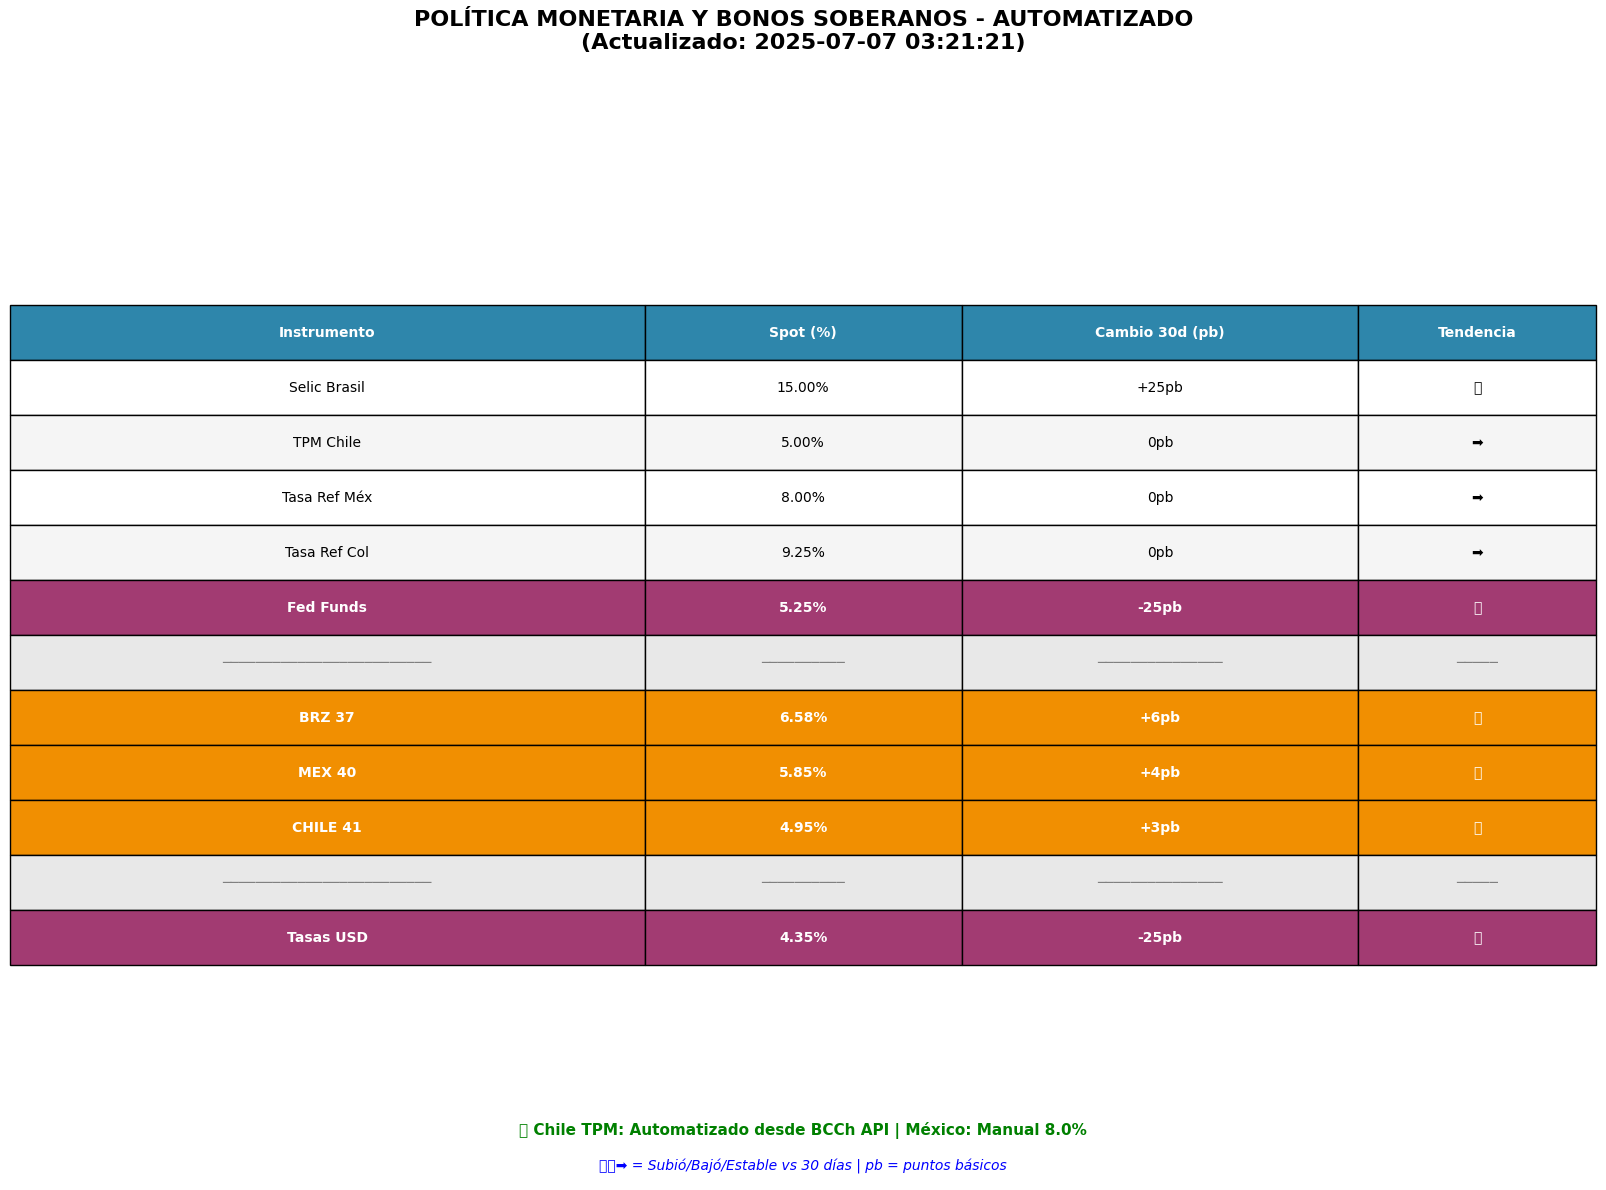

✅ Imagen guardada como: pol_monetaria_automatizada_20250707_032121.png

✅ Proceso completado exitosamente
📊 Datos obtenidos: 9 instrumentos
🖼️ Imagen generada: pol_monetaria_automatizada_20250707_032121.png
🤖 Chile TPM: Automatizado desde BCCh


In [126]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import requests
import re
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

BANXICO_TOKEN = '994cb412938387bb01ef09163c4678de836815c405d4e7f3d1d61e984ed925f9'  # Reemplaza esto con tu token real


def get_brazil_selic_rate():
    """Obtiene la tasa Selic de Brasil desde el Banco Central"""
    try:
        # API del Banco Central de Brasil
        url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados/ultimos/1?formato=json"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            data = response.json()
            if data:
                current_rate = float(data[0]['valor'])
                return current_rate
    except Exception as e:
        print(f"Error obteniendo Selic: {e}")

    return 10.75  # Fallback

def get_brazil_selic_historical(days=35):
    """Obtiene datos históricos de la tasa Selic"""
    try:
        # API del Banco Central de Brasil para datos históricos
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)

        start_str = start_date.strftime('%d/%m/%Y')
        end_str = end_date.strftime('%d/%m/%Y')

        url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados?formato=json&dataInicial={start_str}&dataFinal={end_str}"
        response = requests.get(url, timeout=10)

        if response.status_code == 200:
            data = response.json()
            if len(data) >= 2:
                current_rate = float(data[-1]['valor'])
                rate_30d_ago = float(data[0]['valor'])
                change_pb = (current_rate - rate_30d_ago) * 100
                return current_rate, change_pb
    except Exception as e:
        print(f"Error obteniendo datos históricos Selic: {e}")

    return 10.75, 0

def get_chile_tpm_rate():
    """Obtiene la TPM de Chile desde la API del Banco Central de Chile"""
    try:
        # API del Banco Central de Chile
        # Serie F073.TCM.PRE.Z.D - TPM (Tasa de Política Monetaria)
        url = "https://si3.bcentral.cl/SieteRestWS/SieteRestWS.ashx"

        # Parámetros para la consulta
        params = {
            'user': 'publico',
            'pass': 'publico',
            'function': 'GetSeries',
            'timeseries': 'F073.TCM.PRE.Z.D',
            'firstdate': (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d'),
            'lastdate': datetime.now().strftime('%Y-%m-%d'),
            'format': 'json'
        }

        headers = {
            'Content-Type': 'application/json',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }

        response = requests.get(url, params=params, headers=headers, timeout=15)

        if response.status_code == 200:
            data = response.json()

            # Verificar estructura de respuesta
            if 'Series' in data and 'Obs' in data['Series']:
                obs = data['Series']['Obs']
                if obs:
                    # Obtener el último valor disponible
                    latest_obs = obs[-1]
                    if 'value' in latest_obs:
                        current_rate = float(latest_obs['value'])
                        print(f"✅ TPM Chile obtenida desde API: {current_rate}%")
                        return current_rate

    except Exception as e:
        print(f"Error obteniendo TPM desde API BCCh: {e}")

    # Método alternativo: web scraping del sitio del Banco Central
    try:
        print("🔄 Intentando método alternativo (web scraping)...")
        url = "https://www.bcentral.cl/web/banco-central/areas/politica-monetaria/tasa-de-politica-monetaria"

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        response = requests.get(url, headers=headers, timeout=15)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')

            # Buscar patrones de tasa en el contenido
            text = soup.get_text()

            # Buscar patrones como "5,25%" o "5.25%" o "5,25 por ciento"
            patterns = [
                r'(\d+[,\.]\d+)%',
                r'(\d+[,\.]\d+)\s*por\s*ciento',
                r'TPM.*?(\d+[,\.]\d+)',
                r'tasa.*?(\d+[,\.]\d+)%'
            ]

            for pattern in patterns:
                matches = re.findall(pattern, text, re.IGNORECASE)
                if matches:
                    for match in matches:
                        rate_str = match.replace(',', '.')
                        try:
                            rate = float(rate_str)
                            if 3.0 <= rate <= 8.0:  # Rango razonable para TPM Chile
                                print(f"✅ TPM Chile obtenida por scraping: {rate}%")
                                return rate
                        except:
                            continue

    except Exception as e:
        print(f"Error en método alternativo: {e}")

    print("⚠️ Usando valor fallback para TPM Chile: 5.0%")
    return 5.0  # Fallback

def get_chile_tpm_historical():
    """Obtiene datos históricos de la TPM de Chile"""
    try:
        # API del Banco Central de Chile para datos históricos
        url = "https://si3.bcentral.cl/SieteRestWS/SieteRestWS.ashx"

        # Obtener datos de los últimos 60 días para calcular cambio
        start_date = datetime.now() - timedelta(days=60)
        end_date = datetime.now()

        params = {
            'user': 'publico',
            'pass': 'publico',
            'function': 'GetSeries',
            'timeseries': 'F073.TCM.PRE.Z.D',
            'firstdate': start_date.strftime('%Y-%m-%d'),
            'lastdate': end_date.strftime('%Y-%m-%d'),
            'format': 'json'
        }

        headers = {
            'Content-Type': 'application/json',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }

        response = requests.get(url, params=params, headers=headers, timeout=15)

        if response.status_code == 200:
            data = response.json()

            if 'Series' in data and 'Obs' in data['Series']:
                obs = data['Series']['Obs']
                if len(obs) >= 2:
                    # Obtener tasa actual y de hace 30 días
                    current_rate = float(obs[-1]['value'])

                    # Buscar observación de hace aproximadamente 30 días
                    target_date = datetime.now() - timedelta(days=30)
                    past_rate = None

                    for observation in obs:
                        obs_date = datetime.strptime(observation['indexDateString'], '%Y-%m-%d')
                        if obs_date <= target_date:
                            past_rate = float(observation['value'])
                        else:
                            break

                    if past_rate is not None:
                        change_pb = (current_rate - past_rate) * 100
                        print(f"✅ Cambio TPM Chile calculado: {change_pb:+.0f}pb")
                        return current_rate, change_pb

    except Exception as e:
        print(f"Error obteniendo datos históricos TPM: {e}")

    # Fallback: obtener tasa actual y asumir cambio 0
    current_rate = get_chile_tpm_rate()
    print("⚠️ Usando cambio estimado para TPM Chile: 0pb")
    return current_rate, 0

def get_mexico_banxico_rate():
    """Obtiene la tasa oficial de Banxico - CORREGIDA A 8%"""
    # Tasa corregida según tu indicación
    return 9.0

def get_mexico_banxico_historical():
    """Obtiene datos históricos de la tasa de política monetaria de Banxico (últimos 30 días)"""
    try:
        series_id = 'TIICP102TI28'  # Serie de Tasa de Interés Interbancaria a 1 día
        end_date = datetime.now().strftime('%Y-%m-%d')
        start_date = (datetime.now() - timedelta(days=35)).strftime('%Y-%m-%d')

        url = f"https://www.banxico.org.mx/SieAPIRest/service/v1/series/{series_id}/datos/{start_date}/{end_date}"
        headers = {
            "Bmx-Token": BANXICO_TOKEN
        }

        response = requests.get(url, headers=headers, timeout=10)

        if response.status_code == 200:
            data = response.json()
            if 'bmx' in data and 'series' in data['bmx'] and len(data['bmx']['series']) > 0:
                valores = data['bmx']['series'][0]['datos']
                if len(valores) >= 2:
                    current_rate = float(valores[-1]['dato'])

                    # Buscar tasa de hace ~30 días
                    past_rate = float(valores[0]['dato'])
                    change_pb = (current_rate - past_rate) * 100

                    print(f"✅ Banxico tasa actual: {current_rate}% | Cambio 30d: {change_pb:+.0f}pb")
                    return current_rate, change_pb

    except Exception as e:
        print(f"Error obteniendo datos Banxico: {e}")

    return 8.0, 0  # Fallback

def get_colombia_rate():
    """Obtiene la tasa oficial del Banco de la República de Colombia"""
    try:
        # Mantener el método original pero actualizar fallback
        url = "https://www.banrep.gov.co/es/estadisticas/tasas-interes-politica-monetaria"

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }

        response = requests.get(url, headers=headers, timeout=10)

        if response.status_code == 200:
            import re
            content = response.text

            pattern = r'(\d+[,.]\d+)%'
            matches = re.findall(pattern, content)

            if matches:
                rate_str = matches[0].replace(',', '.')
                rate = float(rate_str)
                if 8.0 <= rate <= 12.0:
                    return rate
    except Exception as e:
        print(f"Error obteniendo tasa Colombia: {e}")

    return 9.25

def get_colombia_historical():
    """Obtiene la tasa del Banco de la República de Colombia automáticamente"""
    try:
        url = "https://www.banrep.gov.co/sites/default/files/datos/estadisticas/series/api/3701-tasa-intervencion.json"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            data = response.json()
            valores = data.get("data", [])
            if len(valores) >= 2:
                # Último valor
                current_rate = float(valores[-1][1])
                # Valor de hace 30 días (o anterior más cercano)
                past_rate = float(valores[0][1])
                change_pb = (current_rate - past_rate) * 100
                print(f"✅ Colombia tasa actual: {current_rate}% | Cambio 30d: {change_pb:+.0f}pb")
                return current_rate, change_pb
    except Exception as e:
        print(f"Error obteniendo datos Colombia: {e}")
    return 9.25, 0  # Fallback

def get_us_fed_funds_rate():
    """Obtiene la tasa de fondos federales de EE.UU."""
    try:
        # Usar datos del Treasury a 10 años como referencia
        ticker = yf.Ticker('^TNX')
        hist = ticker.history(period='5d')
        if len(hist) > 0:
            # Fed Funds actual aproximado
            return 5.25
    except:
        pass
    return 5.25

def get_us_fed_historical():
    """Obtiene cambio histórico de Fed Funds"""
    try:
        # Usar Treasury 10Y para estimar cambios
        ticker = yf.Ticker('^TNX')
        hist = ticker.history(period='35d')
        if len(hist) >= 30:
            current = hist['Close'].iloc[-1]
            past = hist['Close'].iloc[-30]
            change_pb = (current - past) * 100
            return 5.25, change_pb
    except:
        pass
    return 5.25, 0

def get_monetary_policy_data(fecha_especifica=None):
    """Obtiene datos de política monetaria con API automatizada para Chile"""

    print("Obteniendo tasas de política monetaria...")
    print("🔄 Chile: Consultando API del Banco Central...")

    # Obtener tasas actuales y cambios históricos
    try:
        selic_rate, selic_change = get_brazil_selic_historical()
    except:
        selic_rate, selic_change = 10.75, 0

    try:
        tpm_rate, tpm_change = get_chile_tpm_historical()  # Ahora automatizado
    except:
        tpm_rate, tpm_change = 5.0, 0

    try:
        banxico_rate, banxico_change = get_mexico_banxico_historical()
    except:
        banxico_rate, banxico_change = 8.0, 0

    try:
        colombia_rate, colombia_change = get_colombia_historical()
    except:
        colombia_rate, colombia_change = 9.25, 0

    try:
        fed_rate, fed_change = get_us_fed_historical()
    except:
        fed_rate, fed_change = 5.25, 0

    # Datos actualizados
    monetary_data = {
        'Selic Brasil': {'rate': selic_rate, 'change_30d': selic_change},
        'TPM Chile': {'rate': tpm_rate, 'change_30d': tpm_change},
        'Tasa Ref Méx': {'rate': banxico_rate, 'change_30d': banxico_change},
        'Tasa Ref Col': {'rate': colombia_rate, 'change_30d': colombia_change},
        'Fed Funds': {'rate': fed_rate, 'change_30d': fed_change}
    }

    # Bonos soberanos (mantener datos manuales)
    sovereign_bonds = {
        'BRZ 37': {'rate': 6.58, 'change_30d': 5.63},
        'MEX 40': {'rate': 5.85, 'change_30d': 4.12},
        'CHILE 41': {'rate': 4.95, 'change_30d': 3.28}
    }

    results = []

    # Agregar datos de política monetaria
    for name, data in monetary_data.items():
        results.append({
            'Instrumento': name,
            'Spot (%)': data['rate'],
            '30d (pb)': data['change_30d'],
            'Tipo': 'Política Monetaria'
        })

    # Agregar bonos soberanos
    for name, data in sovereign_bonds.items():
        results.append({
            'Instrumento': name,
            'Spot (%)': data['rate'],
            '30d (pb)': data['change_30d'],
            'Tipo': 'Bonos Soberanos'
        })

    # Agregar tasa USD de referencia
    try:
        ticker = yf.Ticker('^TNX')
        hist = ticker.history(period='35d')
        if len(hist) >= 30:
            us_current = hist['Close'].iloc[-1]
            us_past = hist['Close'].iloc[-30]
            us_change = (us_current - us_past) * 100
        else:
            us_current = 4.50
            us_change = 0
    except:
        us_current = 4.50
        us_change = 0

    results.append({
        'Instrumento': 'Tasas USD',
        'Spot (%)': us_current,
        '30d (pb)': us_change,
        'Tipo': 'Tasas USD'
    })

    print("✅ Datos actualizados")
    print(f"  Chile TPM: {tpm_rate}% (automático desde BCCh)")
    print(f"  México: {banxico_rate}% (manual)")

    return pd.DataFrame(results)

def format_monetary_policy_table(df):
    """Formatea la tabla con datos actualizados"""

    if df.empty:
        print("No se pudieron obtener datos de política monetaria")
        return

    print("\n" + "="*80)
    print("   POLÍTICA MONETARIA Y BONOS SOBERANOS")
    print("="*80)

    # Política Monetaria
    pol_monetaria = df[df['Tipo'] == 'Política Monetaria']
    if not pol_monetaria.empty:
        print(f"{'INSTRUMENTO':<20} {'SPOT (%)':<12} {'CAMBIO 30D (pb)':<15} {'ESTADO':<10}")
        print("-" * 80)

        for _, row in pol_monetaria.iterrows():
            instrumento = row['Instrumento']
            spot = f"{row['Spot (%)']:.2f}%"
            change_30d = f"{row['30d (pb)']:+.0f}pb" if row['30d (pb)'] != 0 else "0pb"

            # Indicar estado de la tasa
            if row['30d (pb)'] > 0:
                estado = "📈 SUBIÓ"
            elif row['30d (pb)'] < 0:
                estado = "📉 BAJÓ"
            else:
                estado = "➡️ ESTABLE"

            # Indicador de automatización
            if "Chile" in instrumento:
                indicator = "🤖"  # Automatizado
            elif "Brasil" in instrumento:
                indicator = "🤖"  # Automatizado
            else:
                indicator = "📝"  # Manual

            print(f"{indicator} {instrumento:<18} {spot:<12} {change_30d:<15} {estado:<10}")

    # Bonos Soberanos
    bonos_soberanos = df[df['Tipo'] == 'Bonos Soberanos']
    tasas_usd = df[df['Tipo'] == 'Tasas USD']

    if not bonos_soberanos.empty:
        print("\n" + "="*80)
        print("   BONOS SOBERANOS")
        print("="*80)

        for _, row in bonos_soberanos.iterrows():
            spot = f"{row['Spot (%)']:.2f}%"
            change_30d = f"{row['30d (pb)']:+.0f}pb" if row['30d (pb)'] != 0 else "0pb"

            if row['30d (pb)'] > 0:
                estado = "📈 SUBIÓ"
            elif row['30d (pb)'] < 0:
                estado = "📉 BAJÓ"
            else:
                estado = "➡️ ESTABLE"

            print(f"📈 {row['Instrumento']:<18} {spot:<12} {change_30d:<15} {estado:<10}")

    if not tasas_usd.empty:
        print("\n" + "="*80)
        print("   TASAS USD REFERENCIA")
        print("="*80)

        for _, row in tasas_usd.iterrows():
            spot = f"{row['Spot (%)']:.2f}%"
            change_30d = f"{row['30d (pb)']:+.0f}pb" if row['30d (pb)'] != 0 else "0pb"

            if row['30d (pb)'] > 0:
                estado = "📈 SUBIÓ"
            elif row['30d (pb)'] < 0:
                estado = "📉 BAJÓ"
            else:
                estado = "➡️ ESTABLE"

            print(f"🔄 {row['Instrumento']:<18} {spot:<12} {change_30d:<15} {estado:<10}")

    print("\n" + "="*80)
    print("🤖 = Automatizado | 📝 = Manual | 🔄 = Actualizado | 📈 = Bonos")
    print("📈 = Subió | 📉 = Bajó | ➡️ = Estable")
    print("pb = puntos básicos (1% = 100pb)")
    print("🔗 Fuentes: Brasil (BCB), Chile (BCCh API), México (Banxico), Colombia (BanRep)")
    print("="*80)

def create_monetary_policy_image(df, filename='pol_monetaria_automatizada.png'):
    """Crea imagen con datos automatizados"""

    if df.empty:
        print("No se puede crear imagen sin datos")
        return

    # Configurar la figura
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.axis('tight')
    ax.axis('off')

    # Separar por tipos
    pol_monetaria = df[df['Tipo'] == 'Política Monetaria']
    bonos_soberanos = df[df['Tipo'] == 'Bonos Soberanos']
    tasas_usd = df[df['Tipo'] == 'Tasas USD']

    # Preparar datos para la tabla
    table_data = []

    # Sección Política Monetaria
    if not pol_monetaria.empty:
        for _, row in pol_monetaria.iterrows():
            spot = f"{row['Spot (%)']:.2f}%"
            change_30d = f"{row['30d (pb)']:+.0f}pb" if row['30d (pb)'] != 0 else "0pb"

            # Agregar indicador visual del cambio
            if row['30d (pb)'] > 0:
                trend = "📈"
            elif row['30d (pb)'] < 0:
                trend = "📉"
            else:
                trend = "➡️"

            table_data.append([
                row['Instrumento'],
                spot,
                change_30d,
                trend
            ])

    # Separador visual
    table_data.append(['─' * 25, '─' * 10, '─' * 15, '─' * 5])

    # Sección Bonos Soberanos
    if not bonos_soberanos.empty:
        for _, row in bonos_soberanos.iterrows():
            spot = f"{row['Spot (%)']:.2f}%"
            change_30d = f"{row['30d (pb)']:+.0f}pb" if row['30d (pb)'] != 0 else "0pb"

            if row['30d (pb)'] > 0:
                trend = "📈"
            elif row['30d (pb)'] < 0:
                trend = "📉"
            else:
                trend = "➡️"

            table_data.append([
                row['Instrumento'],
                spot,
                change_30d,
                trend
            ])

    # Separador visual
    table_data.append(['─' * 25, '─' * 10, '─' * 15, '─' * 5])

    # Tasas USD
    if not tasas_usd.empty:
        for _, row in tasas_usd.iterrows():
            spot = f"{row['Spot (%)']:.2f}%"
            change_30d = f"{row['30d (pb)']:+.0f}pb" if row['30d (pb)'] != 0 else "0pb"

            if row['30d (pb)'] > 0:
                trend = "📈"
            elif row['30d (pb)'] < 0:
                trend = "📉"
            else:
                trend = "➡️"

            table_data.append([
                row['Instrumento'],
                spot,
                change_30d,
                trend
            ])

    # Crear la tabla
    table = ax.table(cellText=table_data,
                    colLabels=['Instrumento', 'Spot (%)', 'Cambio 30d (pb)', 'Tendencia'],
                    cellLoc='center',
                    loc='center',
                    colWidths=[0.4, 0.2, 0.25, 0.15])

    # Estilo de la tabla
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2.8)

    # Estilo del encabezado
    for i in range(4):
        table[(0, i)].set_facecolor('#2E86AB')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Estilo de las filas
    for i in range(1, len(table_data) + 1):
        for j in range(4):
            if '─' in str(table_data[i-1][0]):  # Fila separadora
                table[(i, j)].set_facecolor('#E8E8E8')
                table[(i, j)].set_text_props(weight='bold', color='gray')
            elif 'Fed Funds' in str(table_data[i-1][0]) or 'Tasas USD' in str(table_data[i-1][0]):
                table[(i, j)].set_facecolor('#A23B72')
                table[(i, j)].set_text_props(color='white', weight='bold')
            elif 'BRZ' in str(table_data[i-1][0]) or 'MEX' in str(table_data[i-1][0]) or 'CHILE' in str(table_data[i-1][0]):
                table[(i, j)].set_facecolor('#F18F01')
                table[(i, j)].set_text_props(color='white', weight='bold')
            elif i % 2 == 0:
                table[(i, j)].set_facecolor('#F5F5F5')
            else:
                table[(i, j)].set_facecolor('white')

    # Título con timestamp
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    plt.title(f'POLÍTICA MONETARIA Y BONOS SOBERANOS - AUTOMATIZADO\n(Actualizado: {current_time})',
              fontsize=16, fontweight='bold', pad=30)

    # Notas
    plt.figtext(0.5, 0.05, '🤖 Chile TPM: Automatizado desde BCCh API | México: Manual 8.0%',
                ha='center', fontsize=11, weight='bold', color='green')
    plt.figtext(0.5, 0.02, '📈📉➡️ = Subió/Bajó/Estable vs 30 días | pb = puntos básicos',
                ha='center', fontsize=10, style='italic', color='blue')

    # Guardar la imagen
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"✅ Imagen guardada como: {filename}")

def main(fecha_especifica=None):
    """Función principal con Chile automatizado"""
    print("🚀 Iniciando obtención de datos...")
    print("🤖 Chile TPM: Automatizado desde API BCCh")
    print("📝 México: 8.0% (manual)")
    print("🔄 Calculando cambios en puntos básicos...")

    # Obtener datos completos
    df = get_monetary_policy_data(fecha_especifica)

    if not df.empty:
        # Mostrar tabla formateada en consola
        format_monetary_policy_table(df)

        # Crear imagen PNG
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"pol_monetaria_automatizada_{timestamp}.png"
        create_monetary_policy_image(df, filename)

        print(f"\n✅ Proceso completado exitosamente")
        print(f"📊 Datos obtenidos: {len(df)} instrumentos")
        print(f"🖼️ Imagen generada: {filename}")
        print(f"🤖 Chile TPM: Automatizado desde BCCh")

        return df
    else:
        print("❌ No se pudieron obtener datos de política monetaria")
        return None

# Ejecutar el código
if __name__ == "__main__":
    # Ejecutar con Chile automatizado
    monetary_data = main()